In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q ultralytics transformers torchvision

In [ ]:
!pip install --upgrade transformers

In [ ]:
import os
import torch
import shutil
import random
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTModel, ViTConfig
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
original_dataset_dir = "/content/drive/MyDrive/dataset" 
output_dir = "/content/drive/MyDrive/split_dataset"

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for split in ['train', 'val', 'test']:
    split_path = os.path.join(output_dir, split)
    os.makedirs(split_path, exist_ok=True)

for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)

    train_files, temp_files = train_test_split(images, test_size=1 - train_ratio, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

    for split_name, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_class_dir = os.path.join(output_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for fname in split_files:
            src = os.path.join(class_dir, fname)
            dst = os.path.join(split_class_dir, fname)
            shutil.copyfile(src, dst)

print("✅ Dataset has been split and saved to:", output_dir)

✅ Dataset has been split and saved to: /content/drive/MyDrive/split_dataset


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

data_dir = "/content/drive/MyDrive/split_dataset"
batch_size = 16
image_size = 224

Using device: cuda


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [13]:
datasets_dict = {
    "train": datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform),
    "val": datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transform),
    "test": datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transform)
}

dataloaders = {
    split: DataLoader(datasets_dict[split], batch_size=batch_size, shuffle=(split == "train"))
    for split in ["train", "val", "test"]
}

num_classes = len(datasets_dict['train'].classes)


In [ ]:
class YOLOv8FeatureExtractor(nn.Module):
    def __init__(self, model_name='yolov8l.pt'):
        super(YOLOv8FeatureExtractor, self).__init__()
        yolo = YOLO(model_name)
        model = yolo.model.eval()
        for p in model.parameters():
            p.requires_grad = False
        self.feature_extractor = model.model[:8]

    def forward(self, x):
        return self.feature_extractor(x)


class HybridClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HybridClassifier, self).__init__()
        self.yolo_backbone = YOLOv8FeatureExtractor('yolov8l.pt')

        self.patch_embedding = nn.Conv2d(
            in_channels=512,
            out_channels=768,
            kernel_size=4,
            stride=4
        )

        vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
        self.transformer = ViTModel(vit_config)

        for name, param in self.transformer.named_parameters():
            if "encoder.layer.11" in name or "pooler" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.LayerNorm(768),
            nn.Linear(768, num_classes)
        )

    def forward(self, x):
        features = self.yolo_backbone(x)  

        patches = self.patch_embedding(features) 
        B, C, H, W = patches.shape
        patches = patches.view(B, C, H * W).transpose(1, 2)  

        cls_token = torch.zeros(B, 1, C, device=patches.device)  
        vit_input = torch.cat([cls_token, patches], dim=1)  

        pos_embed = self.transformer.embeddings.position_embeddings[:, :vit_input.size(1), :]
        vit_input = vit_input + pos_embed

        encoder_output = self.transformer.encoder(vit_input)  

        if isinstance(encoder_output, tuple):
            cls_output = encoder_output[0][:, 0]  
        else:
            cls_output = encoder_output.last_hidden_state[:, 0]  

        logits = self.classifier(cls_output)
        return logits

In [ ]:
num_classes = 10

model = HybridClassifier(num_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

In [17]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    patience_counter = 0
                    torch.save(model.state_dict(), "best_hybrid_yolov8_vit.pth")
                    print("✅ Best model saved.")
                else:
                    patience_counter += 1
                    print(f"Early stopping patience: {patience_counter}/{patience}")
                    if patience_counter >= patience:
                        print("⏹️ Early stopping triggered.")
                        model.load_state_dict(torch.load("best_hybrid_yolov8_vit.pth"))
                        return history
    return history

In [18]:
history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=40)


Epoch 1/40


100%|██████████| 241/241 [01:29<00:00,  2.70it/s]


train Loss: 0.6828, Acc: 0.7330


100%|██████████| 74/74 [00:19<00:00,  3.78it/s]


val Loss: 0.5935, Acc: 0.7596
✅ Best model saved.

Epoch 2/40


100%|██████████| 241/241 [01:20<00:00,  3.01it/s]


train Loss: 0.5051, Acc: 0.8043


100%|██████████| 74/74 [00:20<00:00,  3.64it/s]


val Loss: 0.4820, Acc: 0.8144
✅ Best model saved.

Epoch 3/40


100%|██████████| 241/241 [01:16<00:00,  3.16it/s]


train Loss: 0.4395, Acc: 0.8339


100%|██████████| 74/74 [00:19<00:00,  3.79it/s]


val Loss: 0.4478, Acc: 0.8144
✅ Best model saved.

Epoch 4/40


100%|██████████| 241/241 [01:14<00:00,  3.23it/s]


train Loss: 0.4002, Acc: 0.8394


100%|██████████| 74/74 [00:18<00:00,  3.94it/s]


val Loss: 0.3990, Acc: 0.8486
✅ Best model saved.

Epoch 5/40


100%|██████████| 241/241 [01:15<00:00,  3.21it/s]


train Loss: 0.3646, Acc: 0.8553


100%|██████████| 74/74 [00:18<00:00,  4.07it/s]


val Loss: 0.3757, Acc: 0.8589
✅ Best model saved.

Epoch 6/40


100%|██████████| 241/241 [01:15<00:00,  3.17it/s]


train Loss: 0.3638, Acc: 0.8571


100%|██████████| 74/74 [00:18<00:00,  4.07it/s]


val Loss: 0.3332, Acc: 0.8666
✅ Best model saved.

Epoch 7/40


100%|██████████| 241/241 [01:15<00:00,  3.18it/s]


train Loss: 0.3381, Acc: 0.8696


100%|██████████| 74/74 [00:18<00:00,  3.91it/s]


val Loss: 0.3103, Acc: 0.8811
✅ Best model saved.

Epoch 8/40


100%|██████████| 241/241 [01:15<00:00,  3.19it/s]


train Loss: 0.3089, Acc: 0.8777


100%|██████████| 74/74 [00:19<00:00,  3.87it/s]


val Loss: 0.3136, Acc: 0.8888
Early stopping patience: 1/5

Epoch 9/40


100%|██████████| 241/241 [01:14<00:00,  3.21it/s]


train Loss: 0.3105, Acc: 0.8766


100%|██████████| 74/74 [00:19<00:00,  3.83it/s]


val Loss: 0.4470, Acc: 0.8033
Early stopping patience: 2/5

Epoch 10/40


100%|██████████| 241/241 [01:15<00:00,  3.21it/s]


train Loss: 0.3036, Acc: 0.8842


100%|██████████| 74/74 [00:19<00:00,  3.79it/s]


val Loss: 0.3479, Acc: 0.8691
Early stopping patience: 3/5

Epoch 11/40


100%|██████████| 241/241 [01:14<00:00,  3.21it/s]


train Loss: 0.2795, Acc: 0.8904


100%|██████████| 74/74 [00:18<00:00,  4.01it/s]


val Loss: 0.2517, Acc: 0.9076
✅ Best model saved.

Epoch 12/40


100%|██████████| 241/241 [01:14<00:00,  3.24it/s]


train Loss: 0.2772, Acc: 0.8933


100%|██████████| 74/74 [00:18<00:00,  4.04it/s]


val Loss: 0.2711, Acc: 0.8999
Early stopping patience: 1/5

Epoch 13/40


100%|██████████| 241/241 [01:14<00:00,  3.22it/s]


train Loss: 0.2632, Acc: 0.8990


100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


val Loss: 0.2928, Acc: 0.8905
Early stopping patience: 2/5

Epoch 14/40


100%|██████████| 241/241 [01:14<00:00,  3.24it/s]


train Loss: 0.2515, Acc: 0.9053


100%|██████████| 74/74 [00:19<00:00,  3.89it/s]


val Loss: 0.2516, Acc: 0.9042
✅ Best model saved.

Epoch 15/40


100%|██████████| 241/241 [01:14<00:00,  3.24it/s]


train Loss: 0.2557, Acc: 0.8980


100%|██████████| 74/74 [00:19<00:00,  3.86it/s]


val Loss: 0.4807, Acc: 0.8161
Early stopping patience: 1/5

Epoch 16/40


100%|██████████| 241/241 [01:14<00:00,  3.25it/s]


train Loss: 0.2462, Acc: 0.9053


100%|██████████| 74/74 [00:19<00:00,  3.80it/s]


val Loss: 0.2290, Acc: 0.9042
✅ Best model saved.

Epoch 17/40


100%|██████████| 241/241 [01:13<00:00,  3.27it/s]


train Loss: 0.2355, Acc: 0.9073


100%|██████████| 74/74 [00:18<00:00,  4.03it/s]


val Loss: 0.2365, Acc: 0.9170
Early stopping patience: 1/5

Epoch 18/40


100%|██████████| 241/241 [01:15<00:00,  3.18it/s]


train Loss: 0.2379, Acc: 0.9120


100%|██████████| 74/74 [00:18<00:00,  4.00it/s]


val Loss: 0.2151, Acc: 0.9230
✅ Best model saved.

Epoch 19/40


100%|██████████| 241/241 [01:15<00:00,  3.19it/s]


train Loss: 0.1939, Acc: 0.9180


100%|██████████| 74/74 [00:18<00:00,  4.04it/s]


val Loss: 0.2519, Acc: 0.9068
Early stopping patience: 1/5

Epoch 20/40


100%|██████████| 241/241 [01:14<00:00,  3.24it/s]


train Loss: 0.2026, Acc: 0.9222


100%|██████████| 74/74 [00:18<00:00,  3.90it/s]


val Loss: 0.1889, Acc: 0.9307
✅ Best model saved.

Epoch 21/40


100%|██████████| 241/241 [01:13<00:00,  3.26it/s]


train Loss: 0.1946, Acc: 0.9297


100%|██████████| 74/74 [00:19<00:00,  3.88it/s]


val Loss: 0.2249, Acc: 0.9145
Early stopping patience: 1/5

Epoch 22/40


100%|██████████| 241/241 [01:14<00:00,  3.25it/s]


train Loss: 0.1896, Acc: 0.9245


100%|██████████| 74/74 [00:19<00:00,  3.79it/s]


val Loss: 0.1984, Acc: 0.9307
Early stopping patience: 2/5

Epoch 23/40


100%|██████████| 241/241 [01:14<00:00,  3.22it/s]


train Loss: 0.1815, Acc: 0.9305


100%|██████████| 74/74 [00:18<00:00,  4.04it/s]


val Loss: 0.2665, Acc: 0.9025
Early stopping patience: 3/5

Epoch 24/40


100%|██████████| 241/241 [01:15<00:00,  3.19it/s]


train Loss: 0.1963, Acc: 0.9253


100%|██████████| 74/74 [00:18<00:00,  4.01it/s]


val Loss: 0.2833, Acc: 0.8896
Early stopping patience: 4/5

Epoch 25/40


100%|██████████| 241/241 [01:13<00:00,  3.29it/s]


train Loss: 0.1397, Acc: 0.9469


100%|██████████| 74/74 [00:19<00:00,  3.87it/s]


val Loss: 0.1749, Acc: 0.9341
✅ Best model saved.

Epoch 26/40


100%|██████████| 241/241 [01:14<00:00,  3.23it/s]


train Loss: 0.1306, Acc: 0.9524


100%|██████████| 74/74 [00:19<00:00,  3.81it/s]


val Loss: 0.1763, Acc: 0.9401
Early stopping patience: 1/5

Epoch 27/40


100%|██████████| 241/241 [01:14<00:00,  3.25it/s]


train Loss: 0.1335, Acc: 0.9508


100%|██████████| 74/74 [00:19<00:00,  3.86it/s]


val Loss: 0.1756, Acc: 0.9333
Early stopping patience: 2/5

Epoch 28/40


100%|██████████| 241/241 [01:14<00:00,  3.23it/s]


train Loss: 0.1200, Acc: 0.9539


100%|██████████| 74/74 [00:18<00:00,  4.06it/s]


val Loss: 0.1698, Acc: 0.9453
✅ Best model saved.

Epoch 29/40


100%|██████████| 241/241 [01:15<00:00,  3.20it/s]


train Loss: 0.0966, Acc: 0.9630


100%|██████████| 74/74 [00:18<00:00,  3.97it/s]


val Loss: 0.1584, Acc: 0.9427
✅ Best model saved.

Epoch 30/40


100%|██████████| 241/241 [01:15<00:00,  3.19it/s]


train Loss: 0.1165, Acc: 0.9552


100%|██████████| 74/74 [00:18<00:00,  4.02it/s]


val Loss: 0.1675, Acc: 0.9512
Early stopping patience: 1/5

Epoch 31/40


100%|██████████| 241/241 [01:13<00:00,  3.26it/s]


train Loss: 0.1088, Acc: 0.9571


100%|██████████| 74/74 [00:18<00:00,  3.94it/s]


val Loss: 0.1632, Acc: 0.9401
Early stopping patience: 2/5

Epoch 32/40


100%|██████████| 241/241 [01:13<00:00,  3.27it/s]


train Loss: 0.1070, Acc: 0.9576


100%|██████████| 74/74 [00:19<00:00,  3.85it/s]


val Loss: 0.1805, Acc: 0.9444
Early stopping patience: 3/5

Epoch 33/40


100%|██████████| 241/241 [01:14<00:00,  3.24it/s]


train Loss: 0.0888, Acc: 0.9656


100%|██████████| 74/74 [00:18<00:00,  4.08it/s]


val Loss: 0.1555, Acc: 0.9487
✅ Best model saved.

Epoch 34/40


100%|██████████| 241/241 [01:15<00:00,  3.21it/s]


train Loss: 0.0941, Acc: 0.9625


100%|██████████| 74/74 [00:17<00:00,  4.12it/s]


val Loss: 0.1338, Acc: 0.9564
✅ Best model saved.

Epoch 35/40


100%|██████████| 241/241 [01:14<00:00,  3.22it/s]


train Loss: 0.1010, Acc: 0.9643


100%|██████████| 74/74 [00:18<00:00,  3.92it/s]


val Loss: 0.1659, Acc: 0.9384
Early stopping patience: 1/5

Epoch 36/40


100%|██████████| 241/241 [01:14<00:00,  3.25it/s]


train Loss: 0.0923, Acc: 0.9688


100%|██████████| 74/74 [00:19<00:00,  3.88it/s]


val Loss: 0.1727, Acc: 0.9410
Early stopping patience: 2/5

Epoch 37/40


100%|██████████| 241/241 [01:14<00:00,  3.24it/s]


train Loss: 0.1135, Acc: 0.9584


100%|██████████| 74/74 [00:19<00:00,  3.74it/s]


val Loss: 0.1507, Acc: 0.9564
Early stopping patience: 3/5

Epoch 38/40


100%|██████████| 241/241 [01:14<00:00,  3.23it/s]


train Loss: 0.0910, Acc: 0.9649


100%|██████████| 74/74 [00:18<00:00,  4.00it/s]


val Loss: 0.1603, Acc: 0.9512
Early stopping patience: 4/5

Epoch 39/40


100%|██████████| 241/241 [01:16<00:00,  3.16it/s]


train Loss: 0.0677, Acc: 0.9742


100%|██████████| 74/74 [00:18<00:00,  3.98it/s]


val Loss: 0.1502, Acc: 0.9564
Early stopping patience: 5/5
⏹️ Early stopping triggered.


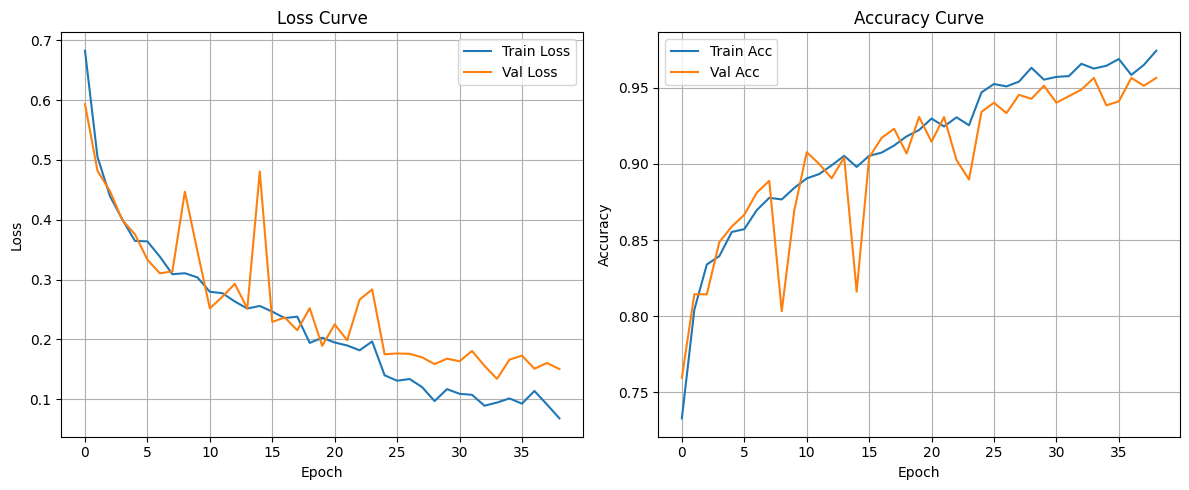

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_plot_yolov8_vit.png")
plt.show()

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    preds, targets = [], []
    correct = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().tolist())
            targets.extend(labels.cpu().tolist())
            correct += (predicted == labels).sum().item()
    acc = correct / len(dataloader.dataset)
    print(f"Test Accuracy: {acc:.4f}")
    return preds, targets

model.load_state_dict(torch.load("best_hybrid_yolov8_vit.pth"))
preds, targets = evaluate(model, dataloaders['test'])

100%|██████████| 75/75 [00:25<00:00,  2.94it/s]

Test Accuracy: 0.9689


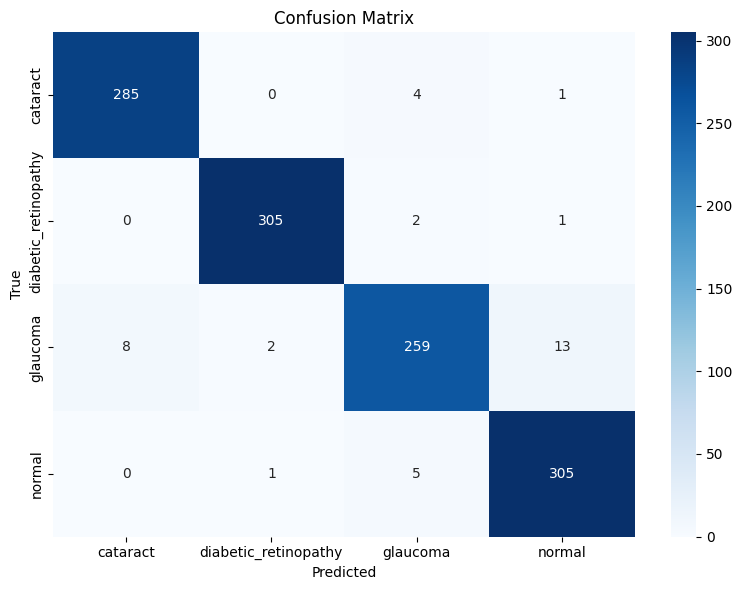

In [ ]:
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=dataloaders['val'].dataset.classes,
            yticklabels=dataloaders['val'].dataset.classes)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_yolov8_vit.png")
plt.show()

In [ ]:
print(classification_report(targets, preds, target_names=datasets_dict['train'].classes))

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'classes': datasets_dict['train'].classes
}, 'hybrid_final_yolov8_vit.pth')

print("Training, evaluation, and saving completed successfully.")


                      precision    recall  f1-score   support

            cataract       0.97      0.98      0.98       290
diabetic_retinopathy       0.99      0.99      0.99       308
            glaucoma       0.96      0.92      0.94       282
              normal       0.95      0.98      0.97       311

            accuracy                           0.97      1191
           macro avg       0.97      0.97      0.97      1191
        weighted avg       0.97      0.97      0.97      1191

Training, evaluation, and saving completed successfully.


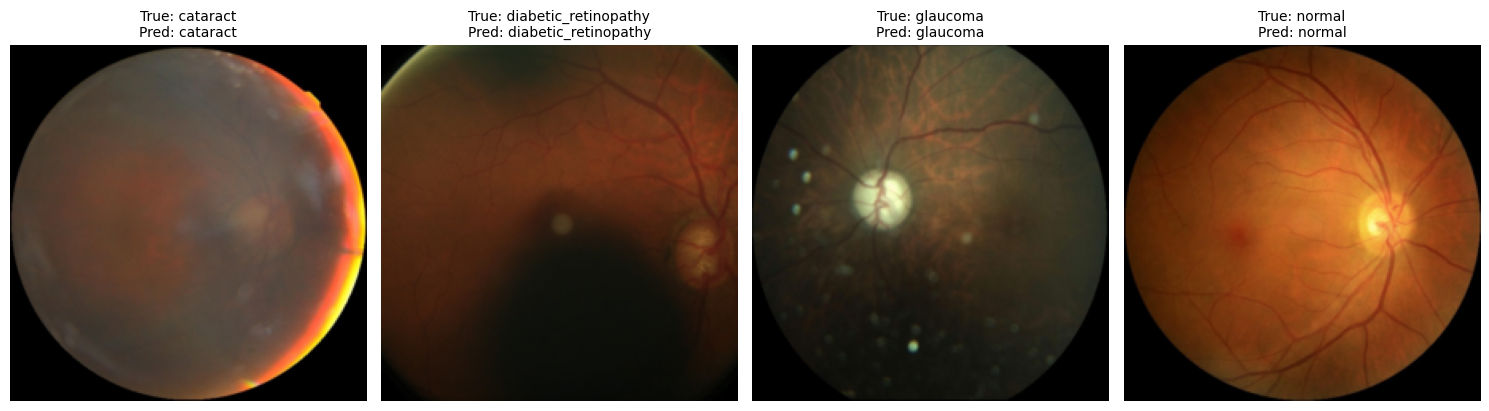

In [ ]:
model.eval()

class_names = datasets_dict['test'].classes
test_dataset = datasets_dict['test']

images_to_test = []
for class_idx, class_name in enumerate(class_names):
    class_indices = [i for i, (_, label) in enumerate(test_dataset) if label == class_idx]
    selected_idx = random.choice(class_indices)
    image, label = test_dataset[selected_idx]
    images_to_test.append((image, label))

plt.figure(figsize=(15, 10))
for i, (image, true_label) in enumerate(images_to_test):
    input_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image_np = np.clip(image_np, 0, 1)

    plt.subplot(1, len(class_names), i + 1)
    plt.imshow(image_np)
    plt.axis("off")
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred.item()]}", fontsize=10)

plt.tight_layout()
plt.show()
